### Initialization Cell

In [30]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import numpy as np, pandas as pd

def chi2(y,yfit):
    res = 0
    for i in range(len(yfit)):
        res = res + (y[i]-yfit[i])**2/(0.9724)**2 #The denominator should be the unbias Sipm voltage in mV
    return (res / len(yfit))

def waveform(x, C, start, m, end, A, d):
    condlist = [x < start, (x >= start) & (x < end), x >= end]
    funclist = [lambda x: C, lambda x: m*x+(C - m*start), lambda x: (A*(np.exp(d*x)-np.exp(d*end)) + m*(end-start) + C)]
    return np.piecewise(x, condlist, funclist)

def gaus(x, normalization, location, stdev):
    return normalization* np.exp(-0.5*((x - location)/stdev)**2)

def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def get_chi2(fitparams,times,voltages):
    startindex=1
    for i in range(len(times)): 
        if times[i] < fitparams[1]: startindex = i
        else: break
    chisq = chi2(voltages[0:startindex],waveform(time[0:startindex], *fitparams))
    return chisq

def get_amplitude_raw(voltages):
    v_max=max(voltages)
    v_min=min(voltages[0:findindex(voltages,v_max)+1])
    return v_max-v_min

def get_amplitude_base(fitparams,voltages):
    v_min = fitparams[0]
    v_max=max(voltages)
    return v_max-v_min

def get_amplitude_fit(fitparams):
    linearrise = fitparams[2]*(fitparams[3]-fitparams[1])
    return linearrise

def get_time_raw(times,voltages):
    prevoltages = voltages[0:findindex(voltages,max(voltages))]
    halfamp = 0.5*(max(voltages)+min(prevoltages))
    halfindex = findindex(voltages,max(voltages))
    haltime = 0
    while voltages[halfindex] - halfamp > 0:
        halfindex -= 1
    if abs(voltages[halfindex] - halfamp) < abs(voltages[halfindex + 1] - halfamp):
        halftime = times[halfindex]
    else: 
        halftime = times[halfindex + 1]
    return halftime

def get_time_base(fitparams,times,voltages):
    halfamp = 0.5*(max(voltages)+fitparams[0])
    halfindex = findindex(voltages,max(voltages))
    haltime = 0
    while voltages[halfindex] - halfamp > 0:
        halfindex -= 1
    if abs(voltages[halfindex] - halfamp) < abs(voltages[halfindex + 1] - halfamp):
        halftime = times[halfindex]
    else: 
        halftime = times[halfindex + 1]
    return halftime

def get_time_fit(fitparams):
    pulse_time = fitparams[1]/2+fitparams[3]/2
    return pulse_time

def get_time_fit_CDF(fitparams):
    pulse_time = fitparams[1]/2+fitparams[3]/2
    return pulse_time

def get_time_half(time, voltage):
    max_index = findindex(voltage, np.max(voltage))
    for i in range(15):
        if voltage[max_index - i - 1] <= voltage[max_index - i]:
            min_voltage = voltage[max_index - i - 1]
    half = 0.5 * (np.max(voltage) + min_voltage)
    index = 0
    for i in range(15):
        if np.abs(voltage[max_index - i - 1] - half) <= np.abs(voltage[max_index - i] - half):
            index = i
    return time[max_index - 1 - index]

### User Defined Inputs

In [52]:
inputfiles = ["300002_short.txt"]  #list input files
outputfile = './rhtrigger15mVor.txt'          #set output file location
filenumber = len(inputfiles)
channelnum = [1,2,3,4]             #list DRS4 board channels to record, ranges 1 to 4
eventview = True

#choose which stats to analyze for each waveform
do_chi2 = 1
do_amplitude_raw = 1
do_amplitude_fit = 1
do_amplitude_base = 1
do_time_raw = 1
do_time_fit = 1
do_time_CDF = 0
do_time_base = 1


#p0:C,start,m,end,A,d -- adjust start and end to match approx time of pulse falling edge
p0=[(0,85,1,95,200,-0.01),       #ch1 initial parameters
    (0,85,1,95,200,-0.01),       #ch2 initial parameters
    (0,100,1,110,200,-0.01),        #ch3 initial parameters
    (0,100,1,110,200,-0.01)]        #ch4 initial parameters
#chi2cut = 2
#Vcut = 20 #cut just above noise level, in (mV) 

channelnames=[]
for ch in channelnum:
    channelnames.append(f'ch{ch}')
#Add each stat to the dataframe
stats=[]
if do_chi2: stats.append("chisq")
if do_amplitude_raw: stats.append("P2P_raw")
if do_amplitude_base: stats.append("P2P_base")
if do_amplitude_fit: stats.append("P2P_fit")
if do_time_raw: stats.append("time_raw")
if do_time_fit: stats.append("time_fit")
if do_time_CDF: stats.append("time_CDF")
if do_time_base: stats.append("time_base")

In [50]:
stats

['chisq',
 'P2P_raw',
 'P2P_base',
 'P2P_fit',
 'time_raw',
 'time_fit',
 'time_base']

### Convert to P2P!

Event Number 1
Channel 1 params: 0.80, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: 0.71, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: 1.11, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: 0.03, 0.0, 0.00, 0.0, 0.00, 1.000


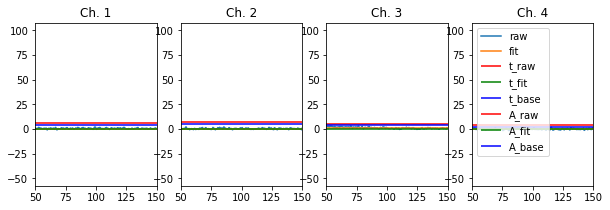

Event Number 2
Channel 1 params: -3.69, 81.5, 7.14, 82.9, 41.68, -0.018
Channel 2 params: -4.13, 83.0, 2.21, 94.0, 107.95, -0.015
Channel 3 params: -3.89, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.86, 97.2, 2.21, 106.6, 77.36, -0.012


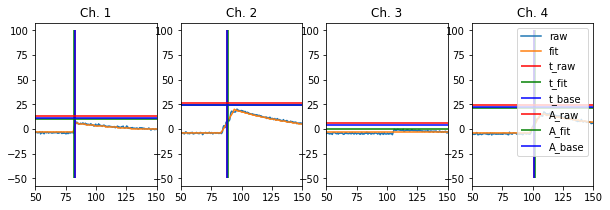

Event Number 3
Channel 1 params: -4.08, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.23, 81.9, 2.47, 95.5, 122.57, -0.013
Channel 3 params: -4.80, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.08, 0.0, 0.00, 0.0, 0.00, 1.000


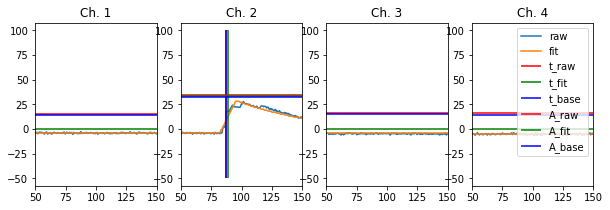

Event Number 4
Channel 1 params: -4.04, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.20, 77.3, 7.97, 80.7, 84.04, -0.013
Channel 3 params: -4.63, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.86, 0.0, 0.00, 0.0, 0.00, 1.000


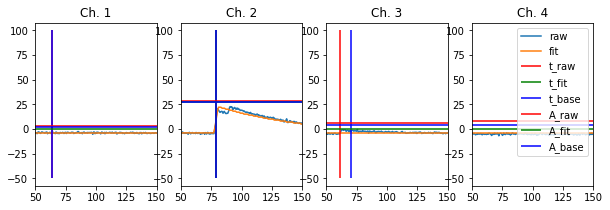

Event Number 5
Channel 1 params: -3.77, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.26, 88.4, 3.74, 96.1, 111.71, -0.014
Channel 3 params: -4.75, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.98, 0.0, 0.00, 0.0, 0.00, 1.000


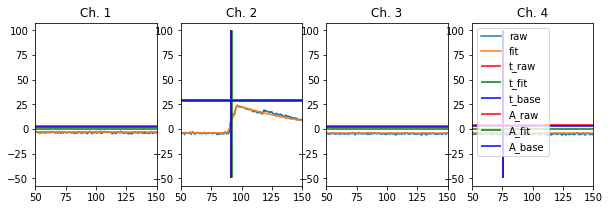

Event Number 6
Channel 1 params: -2.86, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.26, 83.0, 2.49, 98.7, 161.82, -0.014
Channel 3 params: -5.03, 108.1, 2.37, 115.7, 180.94, -0.020
Channel 4 params: -5.62, 97.7, 5.73, 109.4, 380.42, -0.016


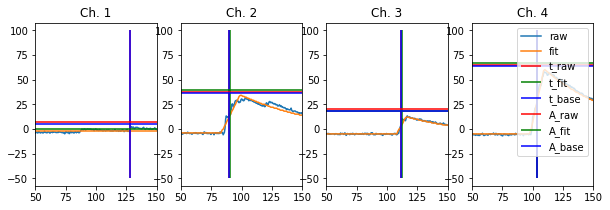

Event Number 7
Channel 1 params: -2.96, 89.9, 6.27, 94.6, 109.04, -0.013
Channel 2 params: -4.34, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -4.02, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.92, 0.0, 0.00, 0.0, 0.00, 1.000


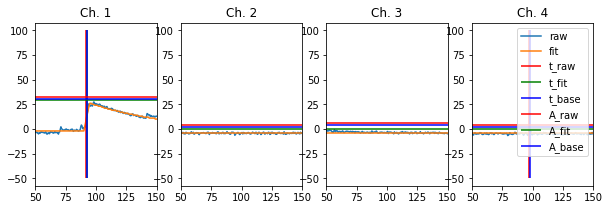

Event Number 8
Channel 1 params: -3.79, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.90, 86.8, 5.24, 91.6, 104.52, -0.015
Channel 3 params: -4.44, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.00, 0.0, 0.00, 0.0, 0.00, 1.000


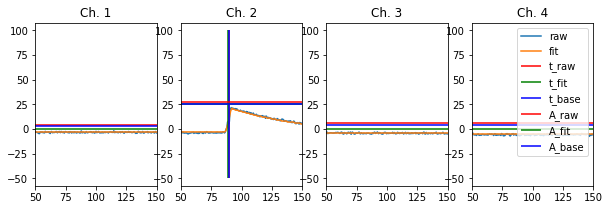

Event Number 9
Channel 1 params: -3.76, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.22, 83.4, 2.10, 97.5, 101.53, -0.012
Channel 3 params: -4.49, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -3.36, 0.0, 0.00, 0.0, 0.00, 1.000


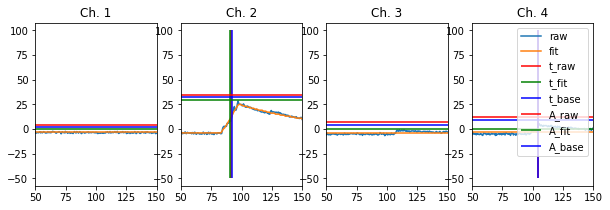

Event Number 10
Channel 1 params: -3.81, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.05, 72.5, 0.98, 99.9, 137.30, -0.016
Channel 3 params: -4.62, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.44, 0.0, 0.00, 0.0, 0.00, 1.000


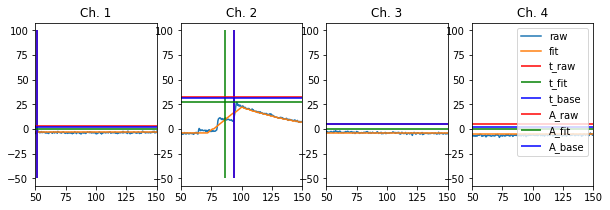

Event Number 11
Channel 1 params: -3.74, 90.2, 23.98, 91.5, 123.95, -0.015
Channel 2 params: -4.04, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -4.82, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.15, 0.0, 0.00, 0.0, 0.00, 1.000


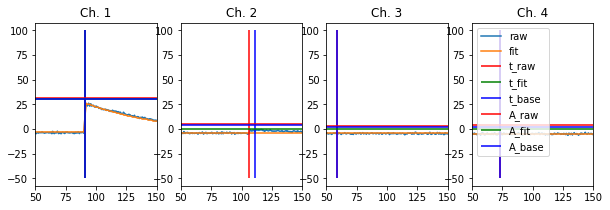

Event Number 12
Channel 1 params: -3.58, 85.7, 5.52, 93.3, 137.14, -0.012
Channel 2 params: -4.16, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -4.89, 102.0, 0.49, 126.8, 127.59, -0.018
Channel 4 params: -5.04, 96.9, 2.66, 110.7, 223.21, -0.016


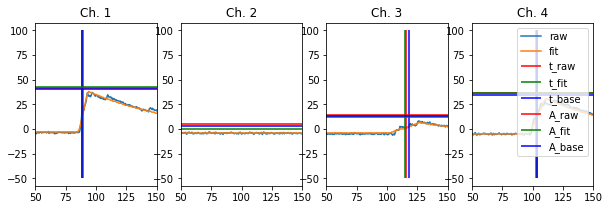

Event Number 13
Channel 1 params: -3.97, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -2.35, 86.0, 5.16, 90.1, 100.00, -0.016
Channel 3 params: -5.17, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.05, 0.0, 0.00, 0.0, 0.00, 1.000


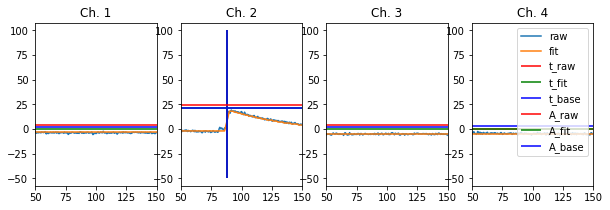

Event Number 14
Channel 1 params: -4.16, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.18, 82.4, 2.22, 92.6, 105.77, -0.016
Channel 3 params: -5.00, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.68, 0.0, 0.00, 0.0, 0.00, 1.000


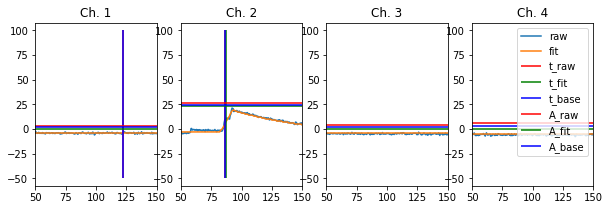

Event Number 15
Channel 1 params: -3.86, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.25, 84.8, 5.39, 89.8, 75.10, -0.011
Channel 3 params: -5.15, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.22, 0.0, 0.00, 0.0, 0.00, 1.000


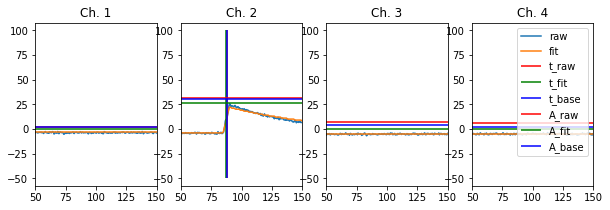

Event Number 16
Channel 1 params: -3.23, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.16, 78.0, 3.20, 85.7, 93.90, -0.015
Channel 3 params: -5.34, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.23, 0.0, 0.00, 0.0, 0.00, 1.000


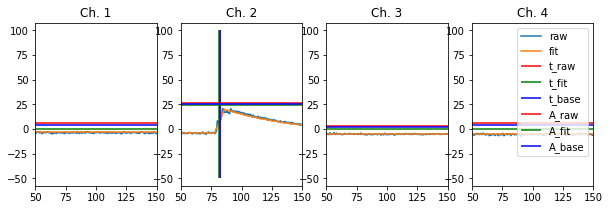

Event Number 17
Channel 1 params: -4.05, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.64, 88.7, 4.18, 95.4, 134.75, -0.016
Channel 3 params: -4.44, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.84, 0.0, 0.00, 0.0, 0.00, 1.000


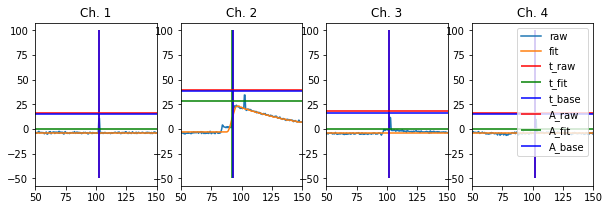

Event Number 18
Channel 1 params: -3.21, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.61, 88.2, 3.53, 98.2, 160.75, -0.015
Channel 3 params: -4.32, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.48, 0.0, 0.00, 0.0, 0.00, 1.000


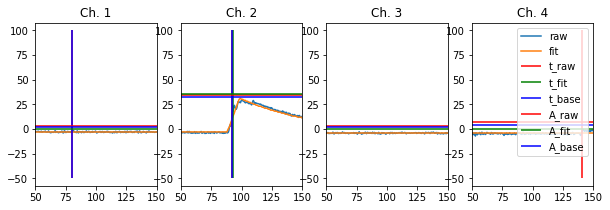

Event Number 19
Channel 1 params: -3.84, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.09, 57.2, 0.65, 92.4, 102.08, -0.016
Channel 3 params: -4.80, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.98, 0.0, 0.00, 0.0, 0.00, 1.000


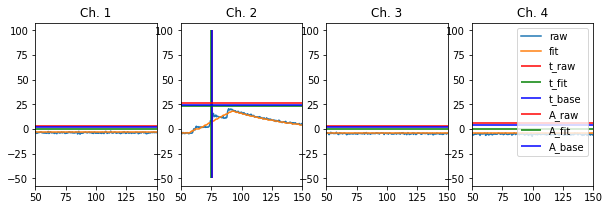

Event Number 20
Channel 1 params: -3.70, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.21, 84.6, 6.17, 88.8, 103.98, -0.015
Channel 3 params: -5.23, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.38, 0.0, 0.00, 0.0, 0.00, 1.000


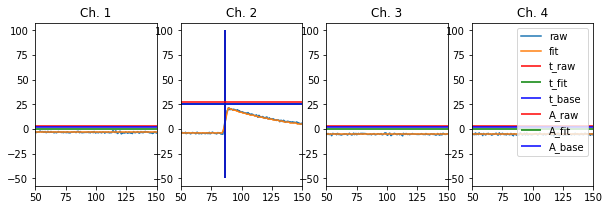

Event Number 21
Channel 1 params: -2.77, 86.1, 0.67, 99.1, 43.88, -0.015
Channel 2 params: -4.26, 86.4, 2.97, 97.3, 141.02, -0.015
Channel 3 params: -4.74, 110.0, 4.00, 121.5, 253.69, -0.014
Channel 4 params: -5.53, 101.2, 4.64, 113.7, 238.50, -0.012


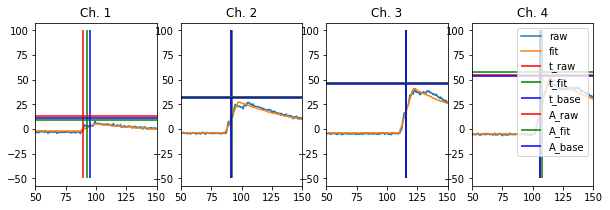

Event Number 22
Channel 1 params: -3.92, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.25, 88.8, 6.81, 100.7, 338.03, -0.014
Channel 3 params: -4.53, 109.8, 1.10, 125.5, 146.38, -0.017
Channel 4 params: -5.15, 101.9, 3.44, 119.7, 324.09, -0.014


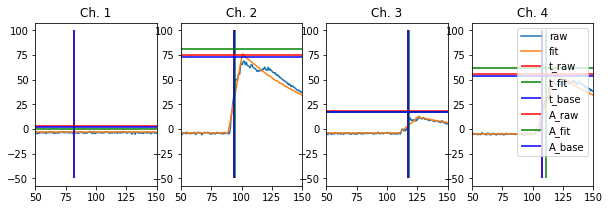

Event Number 23
Channel 1 params: -3.89, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.27, 76.0, 1.39, 93.1, 84.93, -0.013
Channel 3 params: -4.58, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.61, 0.0, 0.00, 0.0, 0.00, 1.000


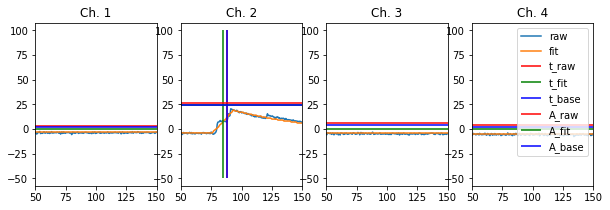

Event Number 24
Channel 1 params: -3.02, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.33, 91.3, 13.59, 93.2, 109.54, -0.015
Channel 3 params: -4.50, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.02, 0.0, 0.00, 0.0, 0.00, 1.000


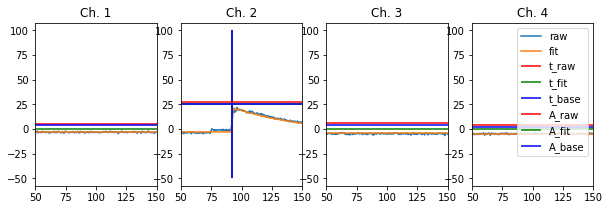

Event Number 25
Channel 1 params: -3.82, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.45, 79.6, 5.18, 84.4, 97.02, -0.016
Channel 3 params: -4.78, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.20, 0.0, 0.00, 0.0, 0.00, 1.000


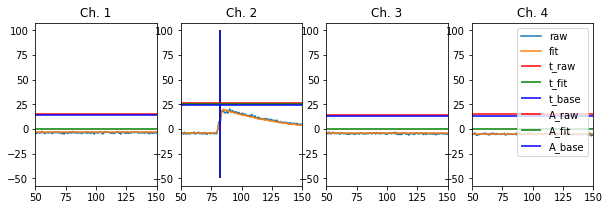

Event Number 26
Channel 1 params: -3.54, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.67, 87.1, 7.72, 90.4, 112.52, -0.016
Channel 3 params: -5.14, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.28, 0.0, 0.00, 0.0, 0.00, 1.000


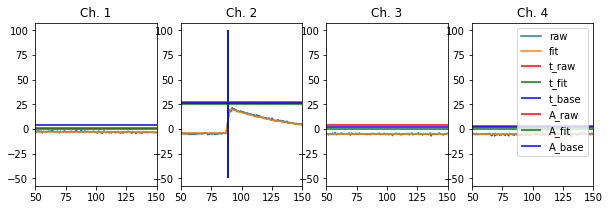

Event Number 27
Channel 1 params: -3.68, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.29, 78.3, 2.27, 89.7, 71.30, -0.011
Channel 3 params: -4.33, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.10, 0.0, 0.00, 0.0, 0.00, 1.000


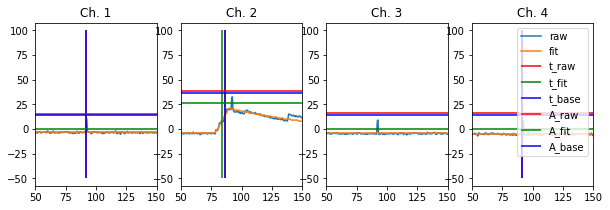

Event Number 28
Channel 1 params: -3.65, 91.1, 2.28, 96.5, 71.42, -0.018
Channel 2 params: -4.06, 84.5, 1.89, 102.6, 88.26, -0.008
Channel 3 params: -4.93, 111.8, 2.25, 121.1, 197.54, -0.018
Channel 4 params: -5.38, 100.4, 2.73, 110.5, 119.76, -0.013


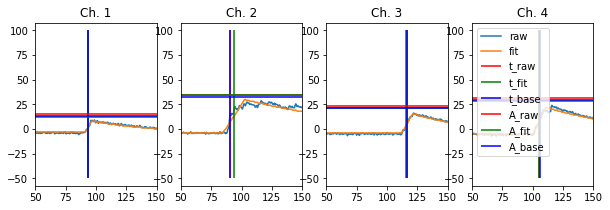

Event Number 29
Channel 1 params: -3.58, 91.5, 0.85, 102.2, 44.01, -0.015
Channel 2 params: -4.30, 88.4, 3.56, 97.2, 108.88, -0.012
Channel 3 params: -4.21, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.73, 99.8, 2.54, 119.8, 377.26, -0.017


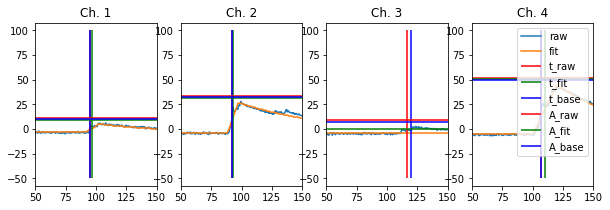

Event Number 30
Channel 1 params: -3.92, 82.2, 2.97, 95.4, 170.49, -0.015
Channel 2 params: -3.93, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -4.59, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -2.68, 91.8, 0.57, 121.3, 109.04, -0.014


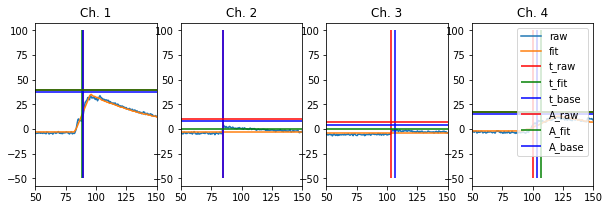

Event Number 31
Channel 1 params: -3.47, 86.9, 6.86, 95.0, 199.59, -0.013
Channel 2 params: -4.06, 89.3, 4.32, 91.6, 55.39, -0.019
Channel 3 params: -4.85, 111.5, 2.76, 118.0, 154.89, -0.018
Channel 4 params: -5.40, 96.7, 1.81, 118.0, 315.15, -0.018


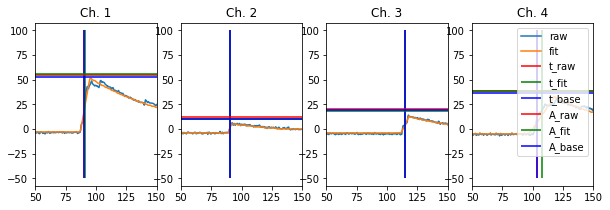

Event Number 32
Channel 1 params: -3.98, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.41, 80.7, 2.65, 90.3, 128.58, -0.018
Channel 3 params: -4.64, 102.0, 1.48, 109.1, 74.51, -0.017
Channel 4 params: -5.31, 90.3, 0.51, 112.2, 74.28, -0.016


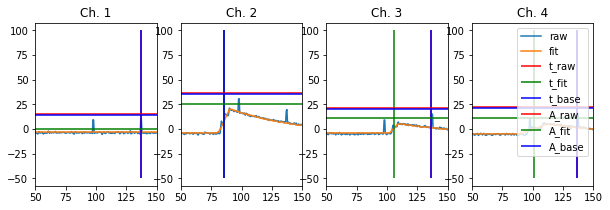

Event Number 33
Channel 1 params: -3.52, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.91, 89.6, 5.54, 98.5, 267.19, -0.017
Channel 3 params: -5.18, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.40, 103.7, 0.88, 120.1, 112.04, -0.017


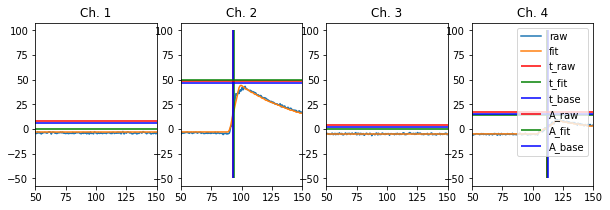

Event Number 34
Channel 1 params: -3.74, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.24, 87.5, 3.95, 94.0, 111.66, -0.015
Channel 3 params: -5.05, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.36, 0.0, 0.00, 0.0, 0.00, 1.000


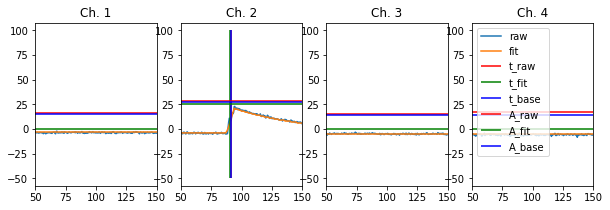

Event Number 35
Channel 1 params: -3.71, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.48, 89.4, 3.90, 98.6, 139.73, -0.013
Channel 3 params: -5.10, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.61, 0.0, 0.00, 0.0, 0.00, 1.000


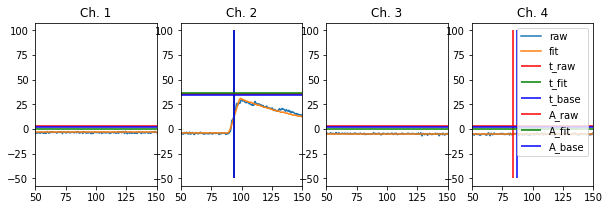

Event Number 36
Channel 1 params: -4.36, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.02, 90.7, 8.48, 93.7, 118.94, -0.016
Channel 3 params: -5.00, 245.8, -0.00, 324.5, -998428721.14, -0.059
Channel 4 params: -5.17, 0.0, 0.00, 0.0, 0.00, 1.000


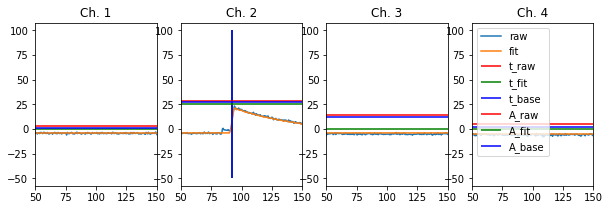

Event Number 37
Channel 1 params: -3.80, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.39, 63.4, 0.80, 96.6, 115.60, -0.015
Channel 3 params: -5.20, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.83, 0.0, 0.00, 0.0, 0.00, 1.000


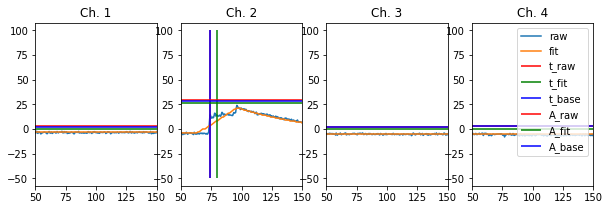

Event Number 38
Channel 1 params: -3.78, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.34, 88.5, 17.71, 90.2, 127.43, -0.016
Channel 3 params: -4.24, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.31, 0.0, 0.00, 0.0, 0.00, 1.000


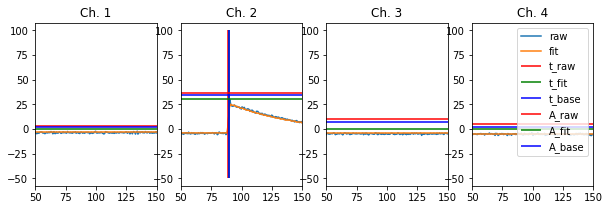

Event Number 39
Channel 1 params: -4.09, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.41, 71.6, 1.38, 88.9, 104.80, -0.016
Channel 3 params: -4.03, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.14, 0.0, 0.00, 0.0, 0.00, 1.000


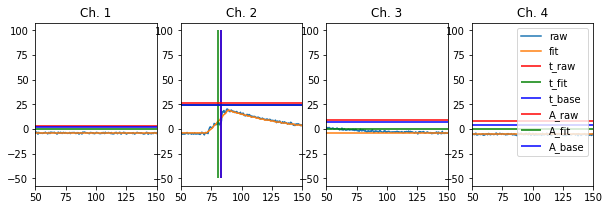

Event Number 40
Channel 1 params: -4.07, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.50, 76.0, 1.08, 98.9, 122.27, -0.016
Channel 3 params: -5.02, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.47, 0.0, 0.00, 0.0, 0.00, 1.000


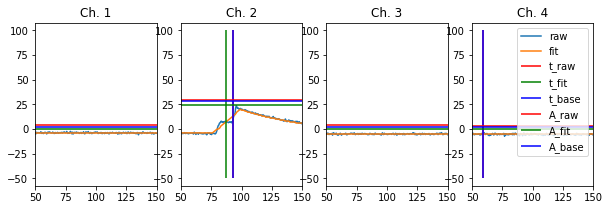

Event Number 41
Channel 1 params: -3.40, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.36, 84.7, 6.49, 88.5, 85.66, -0.014
Channel 3 params: -4.95, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.44, 0.0, 0.00, 0.0, 0.00, 1.000


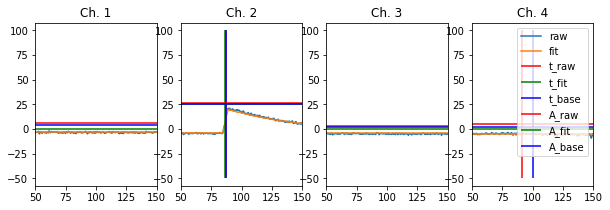

Event Number 42
Channel 1 params: -3.21, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.29, 85.0, 4.10, 94.4, 145.28, -0.014
Channel 3 params: -4.86, 108.0, 2.30, 120.3, 247.70, -0.018
Channel 4 params: -5.36, 99.4, 2.97, 113.0, 248.09, -0.016


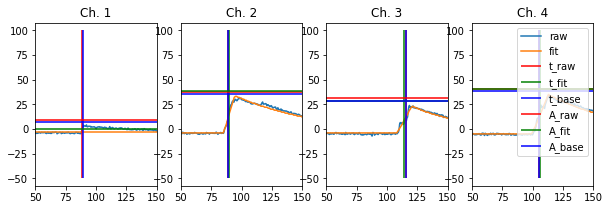

Event Number 43
Channel 1 params: -3.89, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.39, 87.8, 13.85, 89.8, 114.23, -0.016
Channel 3 params: -4.93, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.35, 0.0, 0.00, 0.0, 0.00, 1.000


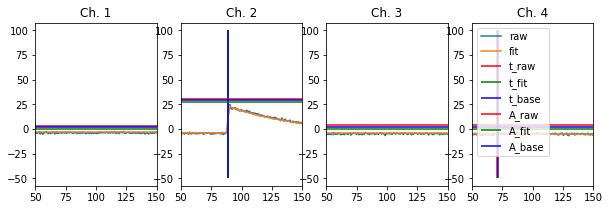

Event Number 44
Channel 1 params: -3.61, 89.2, 7.18, 97.1, 216.58, -0.013
Channel 2 params: -4.41, 90.0, 3.38, 100.2, 189.33, -0.017
Channel 3 params: -3.91, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.16, 104.1, 3.42, 116.7, 260.38, -0.015


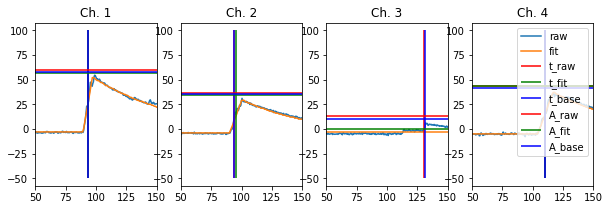

Event Number 45
Channel 1 params: -3.54, 80.0, 1.99, 85.7, 32.79, -0.012
Channel 2 params: -4.39, 79.3, 1.94, 93.0, 119.30, -0.016
Channel 3 params: -4.92, 98.9, 0.77, 111.9, 68.99, -0.018
Channel 4 params: -5.03, 93.2, 3.30, 103.4, 145.54, -0.014


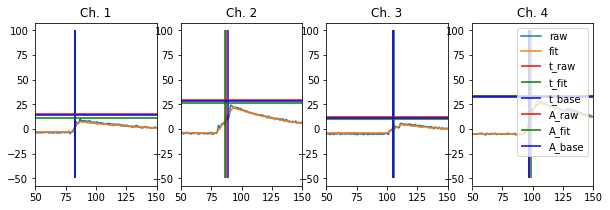

Event Number 46
Channel 1 params: -3.34, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.50, 59.5, 0.57, 99.0, 108.89, -0.015
Channel 3 params: -4.57, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.65, 0.0, 0.00, 0.0, 0.00, 1.000


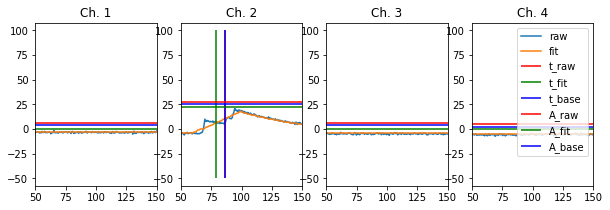

Event Number 47
Channel 1 params: -3.64, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.60, 84.2, 3.90, 93.0, 145.53, -0.015
Channel 3 params: -4.96, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.70, 0.0, 0.00, 0.0, 0.00, 1.000


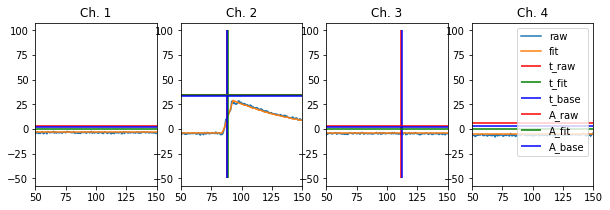

Event Number 48
Channel 1 params: -3.68, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.36, 82.8, 2.35, 94.6, 124.20, -0.016
Channel 3 params: -4.98, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.49, 0.0, 0.00, 0.0, 0.00, 1.000


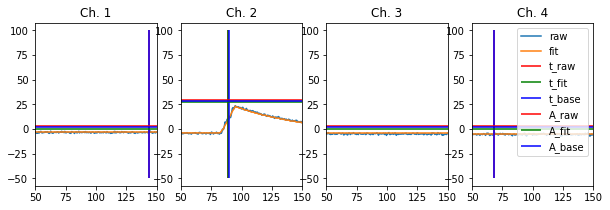

Event Number 49
Channel 1 params: -3.08, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.57, 81.6, 3.26, 90.3, 117.93, -0.016
Channel 3 params: -5.34, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.75, 0.0, 0.00, 0.0, 0.00, 1.000


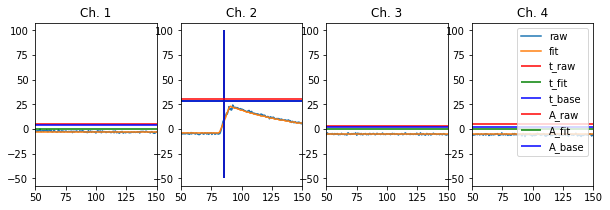

Event Number 50
Channel 1 params: -4.03, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.19, 86.9, 2.88, 96.8, 127.47, -0.015
Channel 3 params: -4.65, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.63, 0.0, 0.00, 0.0, 0.00, 1.000


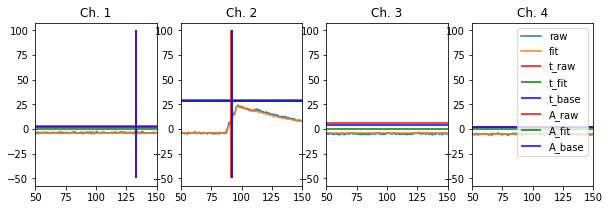

Event Number 51
Channel 1 params: -3.58, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -2.84, 87.9, 8.22, 91.0, 118.54, -0.016
Channel 3 params: -4.52, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.36, 0.0, 0.00, 0.0, 0.00, 1.000


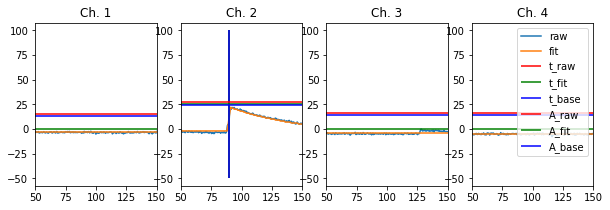

Event Number 52
Channel 1 params: -3.77, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.42, 84.8, 13.40, 86.8, 103.15, -0.015
Channel 3 params: -5.06, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.41, 0.0, 0.00, 0.0, 0.00, 1.000


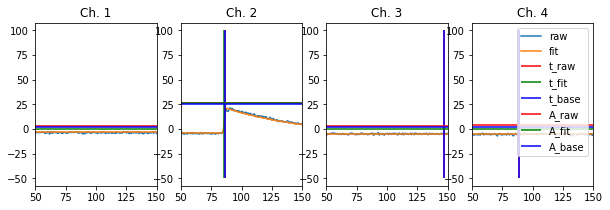

Event Number 53
Channel 1 params: -3.21, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.92, 80.5, 1.55, 101.2, 152.92, -0.015
Channel 3 params: -5.11, 100.3, 0.66, 120.6, 129.83, -0.019
Channel 4 params: -5.32, 96.3, 3.78, 107.7, 146.63, -0.011


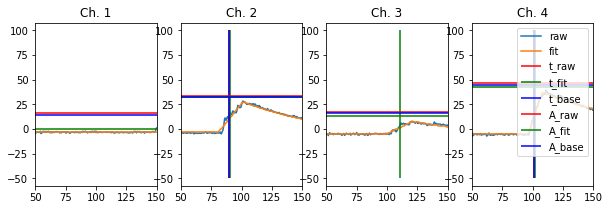

Event Number 54
Channel 1 params: -3.48, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.43, 81.7, 3.90, 88.4, 126.11, -0.018
Channel 3 params: -5.03, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.43, 0.0, 0.00, 0.0, 0.00, 1.000


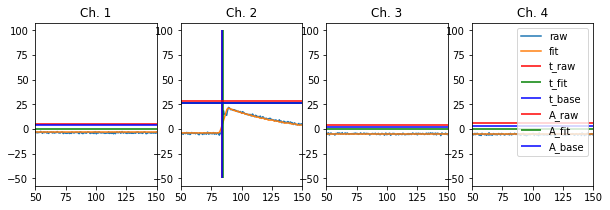

Event Number 55
Channel 1 params: -3.34, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.79, 89.9, 10.35, 92.3, 79.89, -0.012
Channel 3 params: -4.97, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.44, 0.0, 0.00, 0.0, 0.00, 1.000


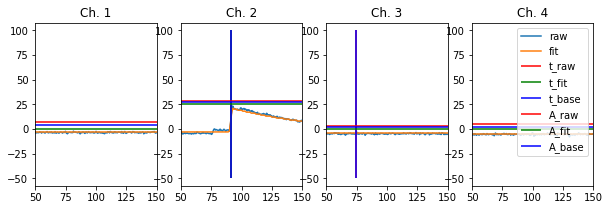

Event Number 56
Channel 1 params: -3.86, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.79, 86.9, 3.75, 93.6, 111.65, -0.015
Channel 3 params: -4.81, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.09, 0.0, 0.00, 0.0, 0.00, 1.000


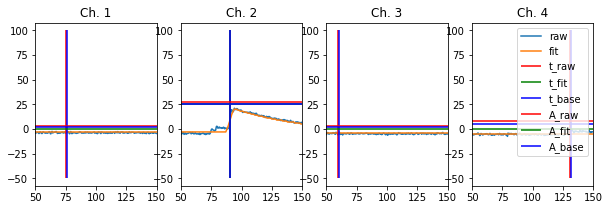

Event Number 57
Channel 1 params: -3.59, 86.3, 1.12, 95.1, 30.22, -0.011
Channel 2 params: -4.19, 88.3, 4.82, 96.7, 155.63, -0.013
Channel 3 params: -4.87, 112.4, 2.05, 123.4, 132.94, -0.014
Channel 4 params: -5.32, 102.6, 5.12, 110.5, 177.19, -0.013


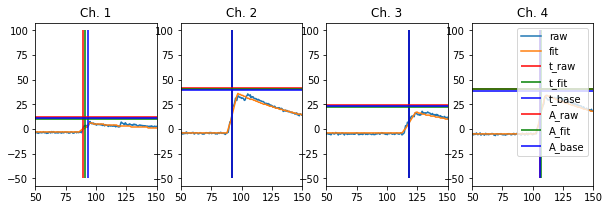

Event Number 58
Channel 1 params: -3.72, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.30, 73.2, 1.45, 90.8, 117.41, -0.017
Channel 3 params: -4.57, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.51, 0.0, 0.00, 0.0, 0.00, 1.000


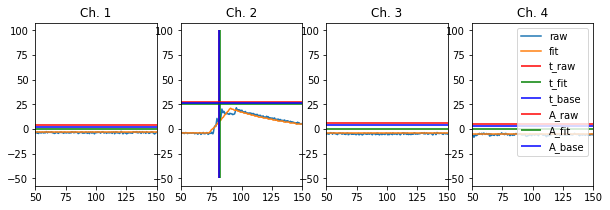

Event Number 59
Channel 1 params: -3.62, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.21, 73.0, 1.66, 88.3, 92.78, -0.014
Channel 3 params: -4.67, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.33, 0.0, 0.00, 0.0, 0.00, 1.000


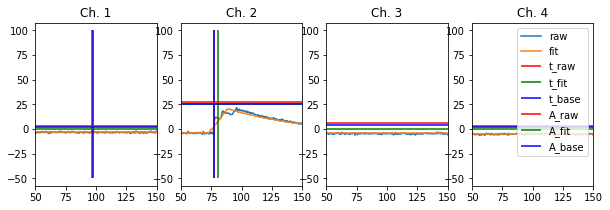

Event Number 60
Channel 1 params: -3.53, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.09, 88.6, 4.57, 94.3, 124.95, -0.016
Channel 3 params: -4.75, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.01, 0.0, 0.00, 0.0, 0.00, 1.000


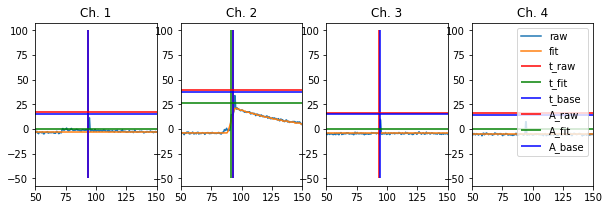

Event Number 61
Channel 1 params: -4.12, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.06, 89.1, 10.80, 91.4, 110.14, -0.016
Channel 3 params: -5.08, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.28, 0.0, 0.00, 0.0, 0.00, 1.000


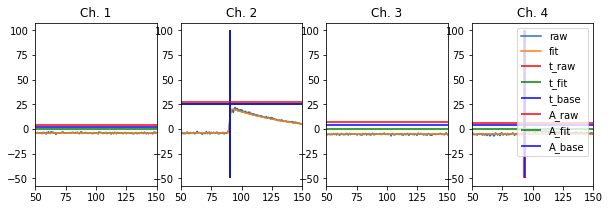

Event Number 62
Channel 1 params: -3.95, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.18, 90.5, 7.64, 94.0, 125.10, -0.016
Channel 3 params: -4.76, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.48, 0.0, 0.00, 0.0, 0.00, 1.000


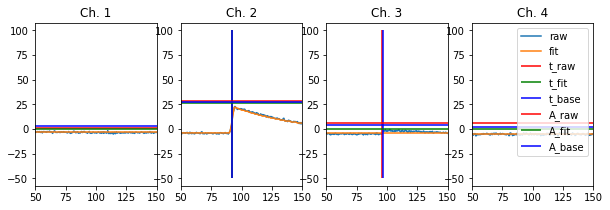

Event Number 63
Channel 1 params: -3.92, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.47, 86.1, 9.73, 88.8, 104.55, -0.015
Channel 3 params: -5.19, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.60, 0.0, 0.00, 0.0, 0.00, 1.000


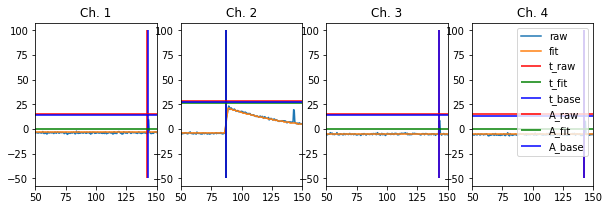

Event Number 64
Channel 1 params: -3.94, 83.7, 4.17, 90.6, 118.62, -0.015
Channel 2 params: -4.56, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -5.20, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.50, 0.0, 0.00, 0.0, 0.00, 1.000


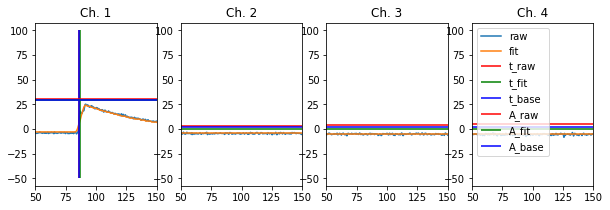

Event Number 65
Channel 1 params: -2.61, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.18, 79.8, 1.72, 93.7, 107.37, -0.016
Channel 3 params: -5.09, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.73, 0.0, 0.00, 0.0, 0.00, 1.000


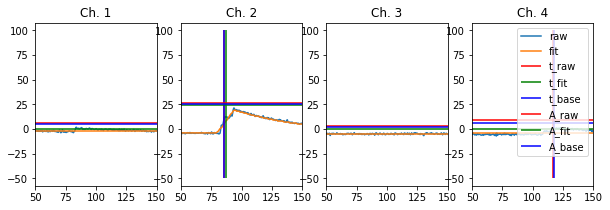

Event Number 66
Channel 1 params: -3.92, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.35, 85.8, 3.88, 97.4, 157.95, -0.012
Channel 3 params: -4.67, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.57, 101.2, 2.08, 110.2, 106.67, -0.016


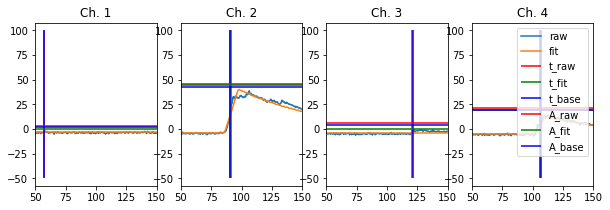

Event Number 67
Channel 1 params: -3.66, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -1.03, 86.2, 4.51, 91.2, 111.42, -0.016
Channel 3 params: -4.36, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.42, 0.0, 0.00, 0.0, 0.00, 1.000


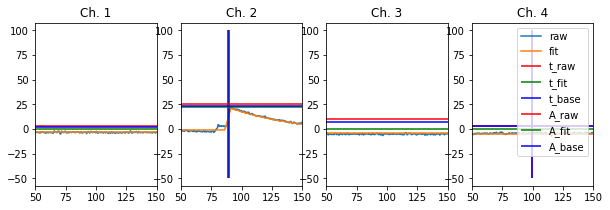

Event Number 68
Channel 1 params: -3.90, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.90, 81.8, 2.97, 91.5, 114.49, -0.015
Channel 3 params: -4.81, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.81, 0.0, 0.00, 0.0, 0.00, 1.000


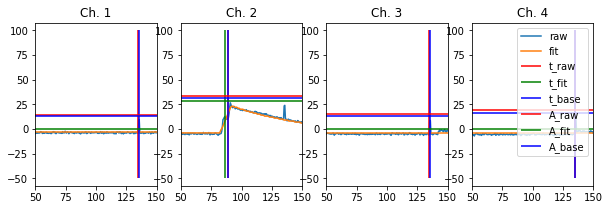

Event Number 69
Channel 1 params: -3.95, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.49, 91.6, 13.73, 93.5, 119.92, -0.016
Channel 3 params: -4.79, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.10, 0.0, 0.00, 0.0, 0.00, 1.000


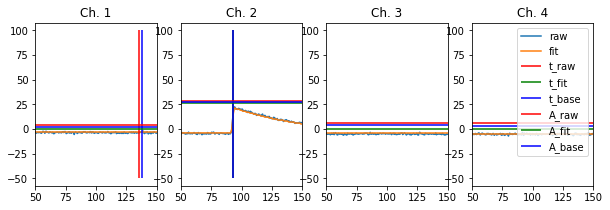

Event Number 70
Channel 1 params: -3.45, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.44, 86.5, 3.08, 95.0, 102.00, -0.013
Channel 3 params: -4.89, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.67, 0.0, 0.00, 0.0, 0.00, 1.000


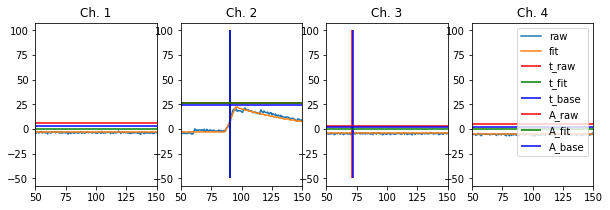

Event Number 71
Channel 1 params: -3.79, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.49, 85.3, 11.22, 87.6, 91.86, -0.014
Channel 3 params: -5.07, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.51, 0.0, 0.00, 0.0, 0.00, 1.000


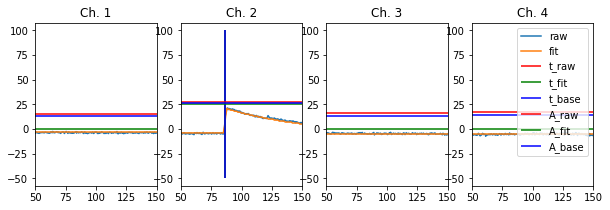

Event Number 72
Channel 1 params: -4.27, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.25, 87.8, 6.31, 91.7, 107.93, -0.015
Channel 3 params: -5.25, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.93, 0.0, 0.00, 0.0, 0.00, 1.000


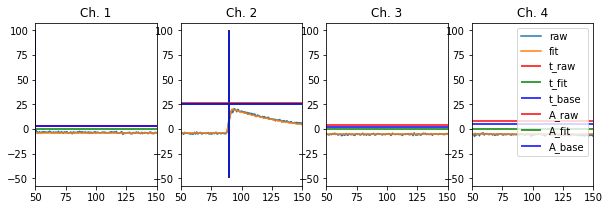

Event Number 73
Channel 1 params: -4.04, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.25, 74.4, 1.72, 87.9, 83.86, -0.014
Channel 3 params: -5.53, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.49, 0.0, 0.00, 0.0, 0.00, 1.000


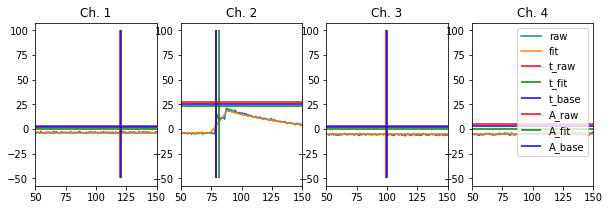

Event Number 74
Channel 1 params: -3.39, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.36, 79.1, 6.74, 82.9, 93.35, -0.015
Channel 3 params: -5.06, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.59, 0.0, 0.00, 0.0, 0.00, 1.000


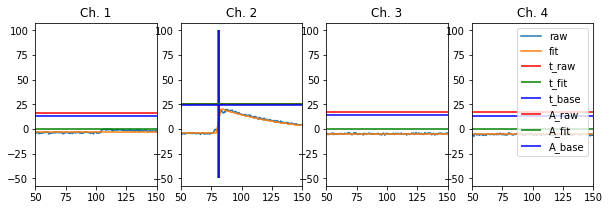

Event Number 75
Channel 1 params: -3.94, 91.3, 20.12, 92.8, 139.47, -0.016
Channel 2 params: -4.69, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -5.41, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.45, 0.0, 0.00, 0.0, 0.00, 1.000


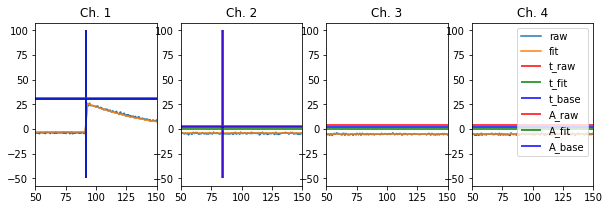

Event Number 76
Channel 1 params: -3.98, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.55, 85.8, 4.40, 91.6, 108.87, -0.016
Channel 3 params: -4.26, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.96, 0.0, 0.00, 0.0, 0.00, 1.000


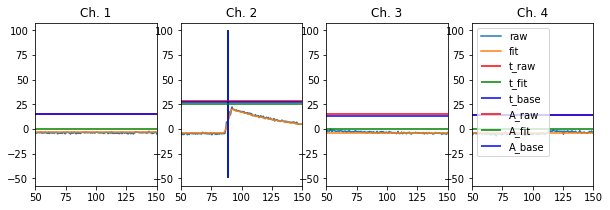

Event Number 77
Channel 1 params: -4.05, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.56, 83.0, 2.98, 97.9, 182.11, -0.014
Channel 3 params: -5.08, 110.2, 3.67, 118.5, 235.96, -0.017
Channel 4 params: -5.46, 98.9, 6.80, 106.8, 208.00, -0.012


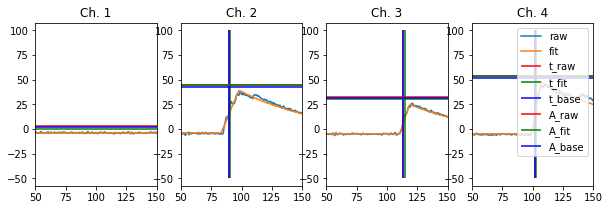

Event Number 78
Channel 1 params: -3.44, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.29, 92.6, 8.21, 100.5, 284.90, -0.014
Channel 3 params: -5.33, 111.8, 2.59, 126.5, 334.66, -0.017
Channel 4 params: -5.29, 102.3, 2.96, 119.0, 282.14, -0.014


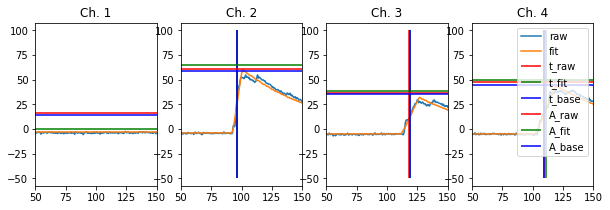

Event Number 79
Channel 1 params: -3.50, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.52, 90.2, 5.72, 94.6, 86.36, -0.013
Channel 3 params: -5.26, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.58, 0.0, 0.00, 0.0, 0.00, 1.000


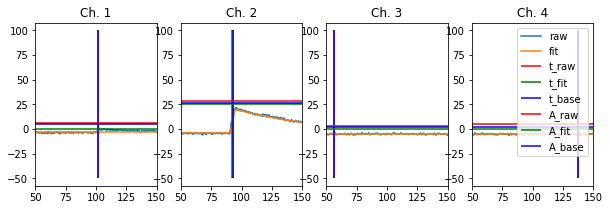

Event Number 80
Channel 1 params: -3.81, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.53, 92.0, 11.99, 94.4, 132.38, -0.016
Channel 3 params: -4.99, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.17, 0.0, 0.00, 0.0, 0.00, 1.000


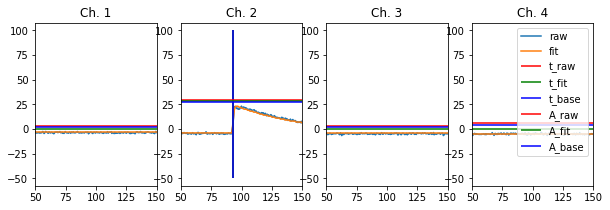

Event Number 81
Channel 1 params: -3.60, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.27, 86.2, 11.77, 88.4, 106.65, -0.016
Channel 3 params: -4.86, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.54, 0.0, 0.00, 0.0, 0.00, 1.000


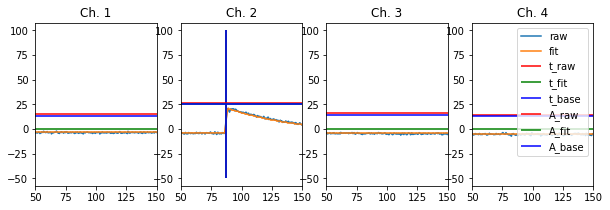

Event Number 82
Channel 1 params: -3.82, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.48, 89.0, 7.39, 92.5, 111.44, -0.016
Channel 3 params: -5.14, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.39, 0.0, 0.00, 0.0, 0.00, 1.000


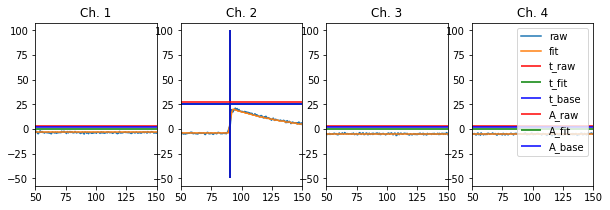

Event Number 83
Channel 1 params: -3.72, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.42, 87.6, 9.68, 90.4, 117.02, -0.015
Channel 3 params: -5.34, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.27, 0.0, 0.00, 0.0, 0.00, 1.000


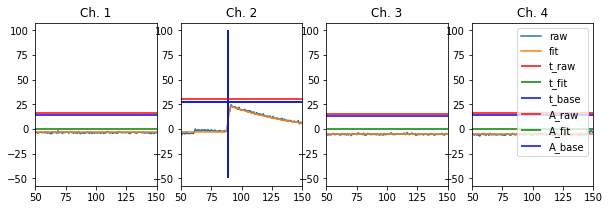

Event Number 84
Channel 1 params: -3.71, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.31, 88.1, 14.45, 90.1, 121.90, -0.016
Channel 3 params: -5.18, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.41, 0.0, 0.00, 0.0, 0.00, 1.000


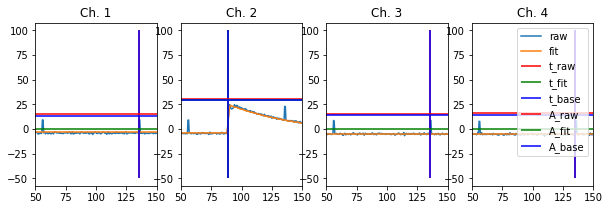

Event Number 85
Channel 1 params: -3.68, 83.2, 1.95, 99.2, 137.62, -0.014
Channel 2 params: -4.45, 88.1, 6.91, 91.9, 112.50, -0.015
Channel 3 params: -4.75, 109.7, 1.94, 116.7, 64.27, -0.013
Channel 4 params: -5.33, 97.7, 4.04, 110.6, 324.42, -0.016


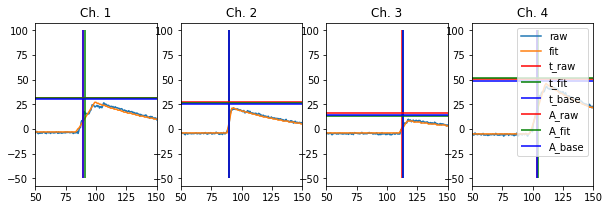

Event Number 86
Channel 1 params: -3.85, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.41, 87.1, 3.32, 97.0, 128.38, -0.014
Channel 3 params: -4.67, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.42, 0.0, 0.00, 0.0, 0.00, 1.000


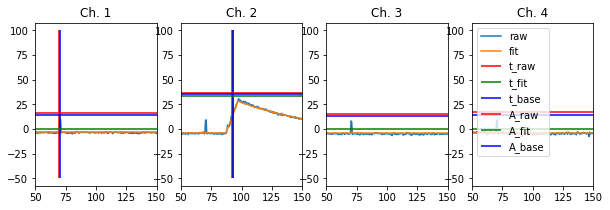

Event Number 87
Channel 1 params: -4.17, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.48, 84.5, 2.16, 97.8, 128.12, -0.015
Channel 3 params: -5.17, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.39, 0.0, 0.00, 0.0, 0.00, 1.000


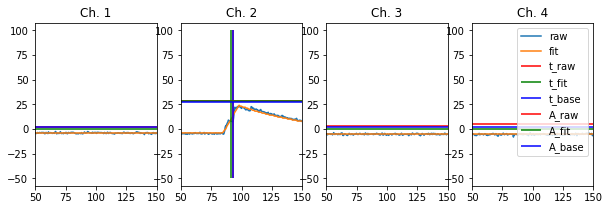

Event Number 88
Channel 1 params: -3.77, 89.5, 15.04, 91.7, 139.30, -0.015
Channel 2 params: -4.67, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -4.90, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.00, 0.0, 0.00, 0.0, 0.00, 1.000


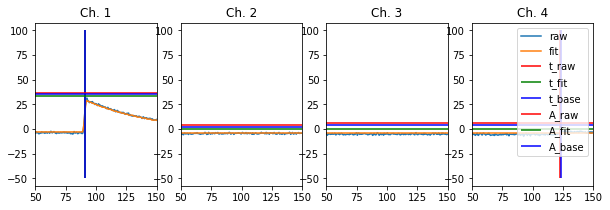

Event Number 89
Channel 1 params: -3.78, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.62, 80.0, 1.47, 97.5, 118.10, -0.015
Channel 3 params: -5.42, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.65, 0.0, 0.00, 0.0, 0.00, 1.000


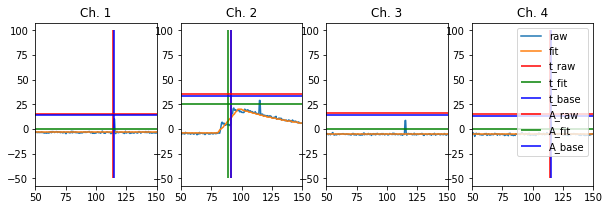

Event Number 90
Channel 1 params: -3.70, 92.5, 5.98, 102.0, 257.91, -0.015
Channel 2 params: -4.44, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -4.94, 113.7, 1.51, 130.9, 374.75, -0.021
Channel 4 params: -5.14, 104.9, 6.62, 120.6, 521.67, -0.013


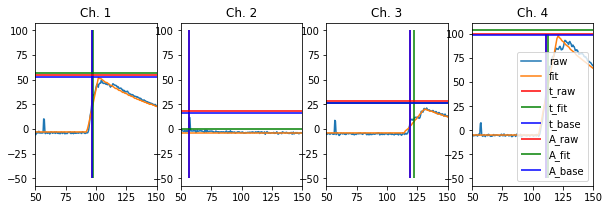

Event Number 91
Channel 1 params: -3.77, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.30, 88.3, 9.68, 90.9, 115.85, -0.016
Channel 3 params: -4.90, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.11, 0.0, 0.00, 0.0, 0.00, 1.000


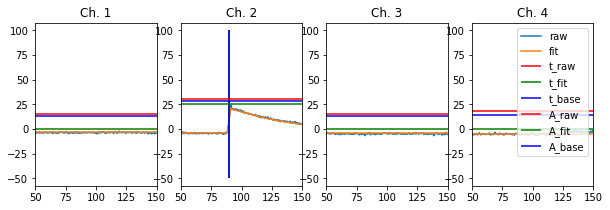

Event Number 92
Channel 1 params: -3.82, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.26, 80.4, 4.09, 86.6, 95.29, -0.015
Channel 3 params: -4.42, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.01, 0.0, 0.00, 0.0, 0.00, 1.000


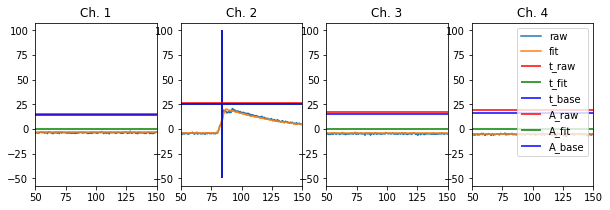

Event Number 93
Channel 1 params: -4.04, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.24, 58.6, 1.63, 73.5, 68.83, -0.013
Channel 3 params: -4.74, 82.4, 0.73, 101.1, 63.00, -0.015
Channel 4 params: -5.87, 76.0, 7.15, 84.5, 219.93, -0.015


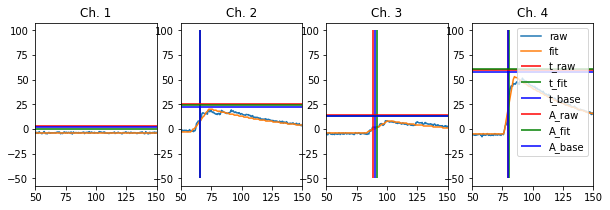

Event Number 94
Channel 1 params: -3.93, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -3.79, 90.9, 14.86, 92.6, 119.38, -0.016
Channel 3 params: -5.23, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -4.84, 0.0, 0.00, 0.0, 0.00, 1.000


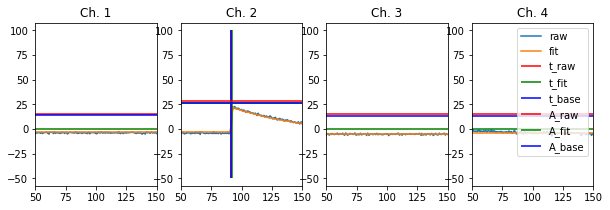

Event Number 95
Channel 1 params: -3.42, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.55, 87.7, 2.45, 103.2, 147.13, -0.013
Channel 3 params: -4.25, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.49, 104.5, 6.23, 114.7, 378.35, -0.015


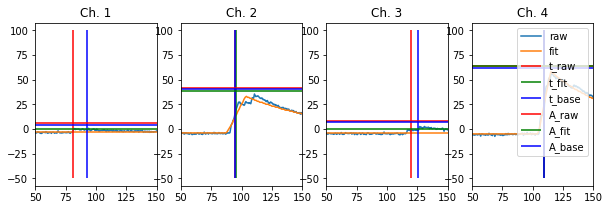

Event Number 96
Channel 1 params: -3.48, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.68, 87.3, 9.25, 97.8, 387.49, -0.014
Channel 3 params: -5.29, 106.1, 2.38, 120.4, 317.10, -0.018
Channel 4 params: -3.91, 101.9, 5.95, 112.4, 263.71, -0.012


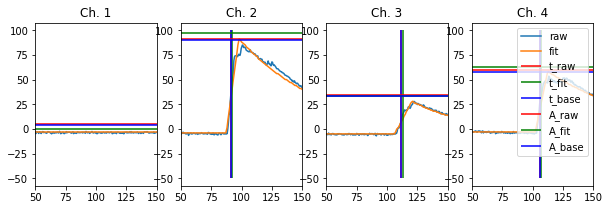

Event Number 97
Channel 1 params: -4.05, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.37, 87.3, 33.49, 88.0, 110.23, -0.016
Channel 3 params: -5.27, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.60, 0.0, 0.00, 0.0, 0.00, 1.000


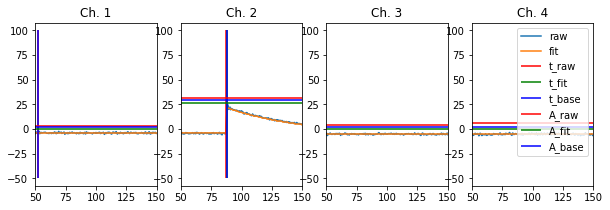

Event Number 98
Channel 1 params: -4.11, 80.7, 1.80, 97.6, 136.63, -0.015
Channel 2 params: -4.74, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -5.03, 101.3, 0.68, 116.3, 96.82, -0.019
Channel 4 params: -5.64, 93.5, 4.11, 107.8, 322.76, -0.016


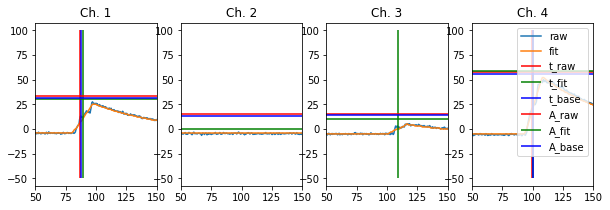

Event Number 99
Channel 1 params: -3.89, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.30, 89.1, 7.96, 94.2, 188.39, -0.016
Channel 3 params: -5.06, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.44, 0.0, 0.00, 0.0, 0.00, 1.000


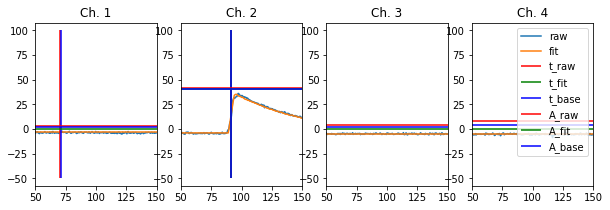

Event Number 100
Channel 1 params: -3.99, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.05, 90.4, 4.95, 95.6, 119.65, -0.016
Channel 3 params: -5.06, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.76, 0.0, 0.00, 0.0, 0.00, 1.000


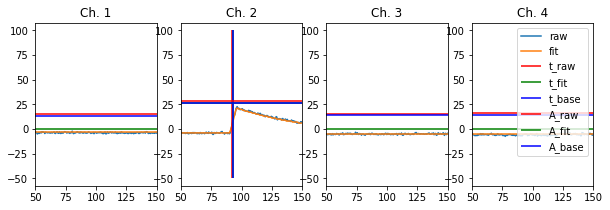

Event Number 101
Channel 1 params: -0.11, 138.5, -0.24, 88.6, 71.17, -0.017
Channel 2 params: -3.43, 68.9, 3.60, 75.5, 55.86, -0.010
Channel 3 params: -2.27, 89.9, 1.18, 103.2, 56.88, -0.010
Channel 4 params: -4.53, 81.8, 2.05, 93.0, 80.17, -0.013


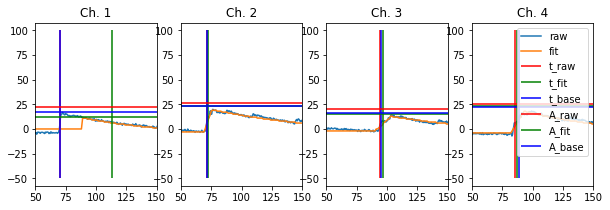

Event Number 102
Channel 1 params: -3.82, 77.2, 16.55, 79.0, 94.59, -0.014
Channel 2 params: -4.82, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 3 params: -5.14, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.60, 0.0, 0.00, 0.0, 0.00, 1.000


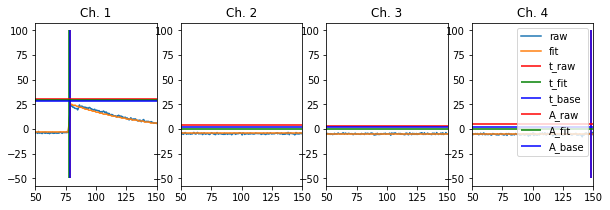

Event Number 103
Channel 1 params: -3.85, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.27, 80.6, 2.39, 90.7, 107.28, -0.016
Channel 3 params: -5.17, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.60, 0.0, 0.00, 0.0, 0.00, 1.000


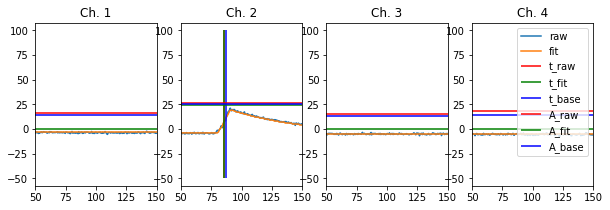

Event Number 104
Channel 1 params: -4.12, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -2.92, 81.0, 1.62, 95.6, 122.01, -0.016
Channel 3 params: -5.40, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.65, 0.0, 0.00, 0.0, 0.00, 1.000


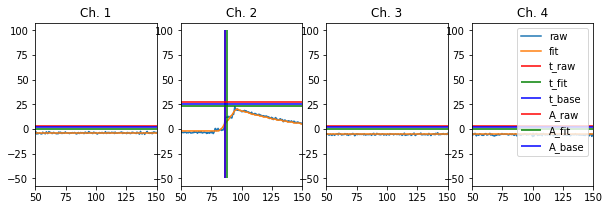

Event Number 105
Channel 1 params: -3.97, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 2 params: -4.39, 82.0, 3.46, 89.3, 105.58, -0.016
Channel 3 params: -5.04, 0.0, 0.00, 0.0, 0.00, 1.000
Channel 4 params: -5.71, 0.0, 0.00, 0.0, 0.00, 1.000


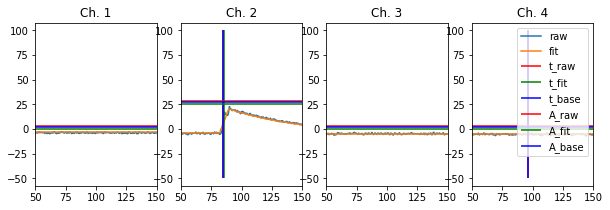

Done!
Total events analyzed: 105


In [63]:
din = {a+"_"+b:[] for a in channelnames for b in stats}

with open(outputfile, 'w') as w:
    #w.write("")
    for i in range(0, filenumber):                             #iterate through files
        w.write(f"File {i}, Channel(s) {channelnum}, stats {stats}")
        with open(inputfiles[i]) as f:
            current_file = (f.read().split('-- Event'))
        
        for j in range(1, len(current_file)):                  #iterate through events 
            
            time = np.array([])
            voltage = [np.array([])]*4
            lines = current_file[j].split('\n')
            
            if eventview: #show the waveform fit line
                print(f"Event Number {j}")
                fig,ax = plt.subplots(1,4,figsize=(10,3))
                ax[0].set_title("Ch. 1")
                ax[1].set_title("Ch. 2")
                ax[2].set_title("Ch. 3")
                ax[3].set_title("Ch. 4")
            
            for line in lines[6:1028]:                         #iterate through data points
                values = line.split()
                time = np.append(time, float(values[2]))
                for channel in channelnum:
                    #if float(values[channel+2]) < Vcut: continue            #cut the false peaks from the DRS4 -- mismatches length of time list
                    voltage[channel-1] = np.append(voltage[channel-1], float(values[channel+2]))
            w.write('\n')
            for channel in channelnum:
                print(f"Event: {j}, Channel: {channel}",end="\r") #,end="\r"
                #only attempt a fit if it looks like there's not nothing
                totalrms = sum((voltage[channel-1]-np.mean(voltage[channel-1]))**2)/len(voltage[channel-1])
                if totalrms < 5:
                    popt = (np.mean(voltage[channel-1]),0,0,0,0,1)
                    
                    if do_chi2:
                        chisq = 0
                        din[f'ch{channel}_chisq'].append(chisq)
                        w.write(f"{chisq:.2f}\t")

                    #calculate amplitude
                    if do_amplitude_raw: 
                        amplitude = 0
                        din[f'ch{channel}_P2P_raw'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_base: 
                        amplitude = 0
                        din[f'ch{channel}_P2P_base'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_fit: 
                        amplitude = 0
                        din[f'ch{channel}_P2P_fit'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    #calculate time
                    if do_time_raw: 
                        pulse_time = 0
                        din[f'ch{channel}_time_raw'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                    if do_time_fit: 
                        pulse_time = 0
                        din[f'ch{channel}_time_fit'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                    if do_time_base:
                        pulse_time = 0
                        din[f'ch{channel}_time_base'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                else:
                    popt, pcov = curve_fit(waveform, time, voltage[channel-1],p0=p0[channel-1],
                                           maxfev = 100000)#,bounds=([-10,60,0,60,0,-1],[10,140,100,140,3000,0])
                #calculate chi^2
                    if do_chi2:
                        chisq = get_chi2(popt,time,voltage[channel-1])
                        din[f'ch{channel}_chisq'].append(chisq)
                        w.write(f"{chisq:.2f}\t")

                    #calculate amplitude
                    if do_amplitude_raw: 
                        amplitude = get_amplitude_raw(voltage[channel-1])
                        din[f'ch{channel}_P2P_raw'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_base: 
                        amplitude = get_amplitude_base(popt,voltage[channel-1])
                        din[f'ch{channel}_P2P_base'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    if do_amplitude_fit: 
                        amplitude = get_amplitude_fit(popt)
                        din[f'ch{channel}_P2P_fit'].append(amplitude)
                        w.write(f"{amplitude:.1f}\t")

                    #calculate time
                    if do_time_raw: 
                        pulse_time = get_time_raw(time,voltage[channel-1])
                        din[f'ch{channel}_time_raw'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                    if do_time_fit: 
                        pulse_time = get_time_fit(popt)
                        din[f'ch{channel}_time_fit'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                    if do_time_base:
                        pulse_time = get_time_base(popt, time, voltage[channel - 1])
                        din[f'ch{channel}_time_base'].append(pulse_time)
                        w.write(f"{pulse_time:.1f}\t")

                if eventview: #show the waveform fit line
                    print(f"Channel {channel} params: {popt[0]:.2f}, {popt[1]:.1f}, {popt[2]:.2f}, {popt[3]:.1f}, {popt[4]:.2f}, {popt[5]:.3f}")
                    xs = []
                    ys = []
                    for i in range(500):
                        xs.append(i)
                        ys.append(waveform(i,*popt))
                    ax[channel-1].plot(time,voltage[channel-1],label="raw")
                    ax[channel-1].plot(xs,ys,label="fit")
                    ax[channel-1].set_xlim(50,150)
                    #ax[channel-1].set_ylim(-25,25)
                    #draw the P2P and time 
                    if do_time_raw: ax[channel-1].vlines(get_time_raw(time,voltage[channel-1]),ymin=-50,ymax=100, color='r',label="t_raw")
                    if do_time_fit: ax[channel-1].vlines(get_time_fit(popt),ymin=-50,ymax=100, color='g',label="t_fit")
                    if do_time_base: ax[channel-1].vlines(get_time_base(popt,time,voltage[channel-1]),ymin=-50,ymax=100, color='b',label="t_base")
                    if do_amplitude_raw: ax[channel-1].hlines(get_amplitude_raw(voltage[channel-1]),xmin=0,xmax=200, color='r',label="A_raw")
                    if do_amplitude_fit: ax[channel-1].hlines(get_amplitude_fit(popt),xmin=0,xmax=200, color='g',label="A_fit")
                    if do_amplitude_base: ax[channel-1].hlines(get_amplitude_base(popt,voltage[channel-1]),xmin=0,xmax=200, color='b',label="A_base")
            
            if eventview:
                plt.legend()        
                plt.show()
                
print(f'Done!\nTotal events analyzed: {len(din["ch2_chisq"])}')
dfin = pd.DataFrame(din)

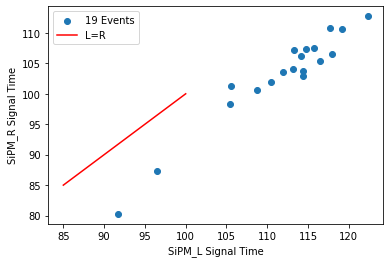

In [64]:
plt.scatter(dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit,label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")
plt.plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
plt.xlabel("SiPM_L Signal Time")
plt.ylabel("SiPM_R Signal Time")
plt.legend()
plt.show()

### How to read the output file into DataFrame:

In [66]:
with open(outputfile) as f:  
    stats = []
    nchannelnames=[]
    nevents = (f.read().split('\n'))
    nchannelnums = nevents[0].split('[')[1].split(']')[0].split(', ')
    for ch in nchannelnums:
        nchannelnames.append(f'ch{ch}')
    for i in range(len(nevents[0].split('[')[2].split(']')[0].split("'"))//2):
        stats.append(nevents[0].split('[')[2].split(']')[0].split("'")[2*i+1])

    dout = {a+"_"+b:[] for a in nchannelnames for b in stats}
    for event in nevents[:]:
        #print(f'Event: {event}')
        nvalues = event.split()
        if len(nvalues) != len(stats)*len(nchannelnames): continue
        for i in range(len(nchannelnames)):
            for j in range(len(stats)):
                dout[f'{nchannelnames[i]}_{stats[j]}'].append(float(nvalues[len(stats)*i+j]))
    #print(dout)
dfout = pd.DataFrame(dout)

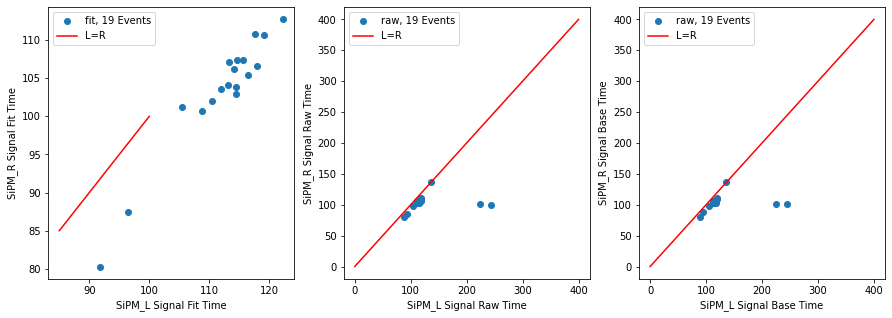

In [67]:
fig,ax=plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,dfout.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit,label=f"fit, {len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")
ax[1].scatter(dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_raw,dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_raw,label=f"raw, {len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_raw)} Events")
ax[2].scatter(dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_base,dfout.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_base,label=f"raw, {len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_base)} Events")
ax[0].plot(np.linspace(85,100,2),np.linspace(85,100,2),color="red",label="L=R")
ax[0].set_xlabel("SiPM_L Signal Fit Time")
ax[0].set_ylabel("SiPM_R Signal Fit Time")
ax[1].plot(np.linspace(0,400,2),np.linspace(0,400,2),color="red",label="L=R")
ax[1].set_xlabel("SiPM_L Signal Raw Time")
ax[1].set_ylabel("SiPM_R Signal Raw Time")
ax[2].plot(np.linspace(0,400,2),np.linspace(0,400,2),color="red",label="L=R")
ax[2].set_xlabel("SiPM_L Signal Base Time")
ax[2].set_ylabel("SiPM_R Signal Base Time")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

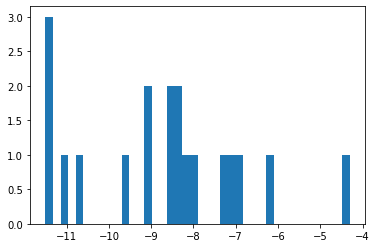

In [68]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch4_time_fit-dfin.query("ch3_P2P_fit>10 & ch4_P2P_fit>10").ch3_time_fit,40, label=f"{len(dfin.query('ch3_P2P_fit>10 & ch4_P2P_fit>10').ch4_time_fit)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-20,10,50),gaus(np.linspace(-20,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.legend()
plt.show()

Actual Average: -22.06, Actual st.dev.: 38.66
Fit Average:    0.03, Fit st.dev.:    0.06


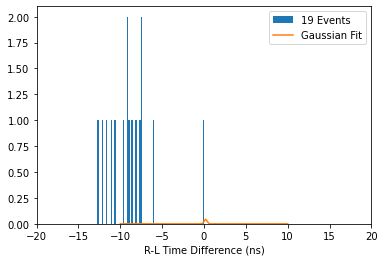

In [69]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_raw-dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_raw,900, label=f"{len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_raw)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count,maxfev=1000000,p0=)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-10,10,50),gaus(np.linspace(-10,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.xlim(-20,20)
plt.legend()
plt.show()

Actual Average: -22.16, Actual st.dev.: 38.53
Fit Average:    0.03, Fit st.dev.:    0.06


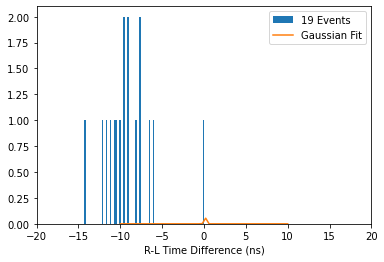

In [70]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch4_time_base-dfin.query("ch3_P2P_raw>10 & ch4_P2P_raw>10").ch3_time_base,900, label=f"{len(dfin.query('ch3_P2P_raw>10 & ch4_P2P_raw>10').ch4_time_base)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count,maxfev=10000000)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-10,10,50),gaus(np.linspace(-10,10,50),*coeff),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.xlim(-20,20)
plt.legend()
plt.show()